<a href="https://colab.research.google.com/github/Epilef86/Recomendacoes_/blob/main/Content_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

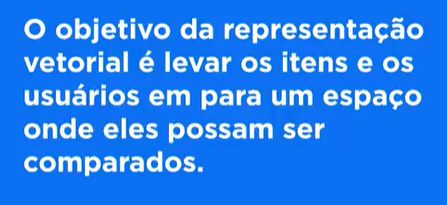

geralmente os itens tem determinadas características, os usuários têm outras características e a ideia da recomendação em um dos modelos é conseguir comparar o usuário com o item e ver se eles são similares. A ideia dessa representação vetorial é justamente converter a entidade do tipo item ou a entidade do tipo usuário nesse espaço n-dimensional em que a gente consiga compará-los.

Quando estamos falando em representação vetoriais, precisamos de um modelo gerador de vetores, que é a entidade matemática que fazemos as comparações.

Existem diversos geradores de vetores:

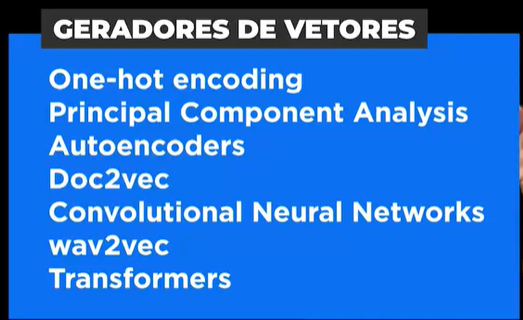

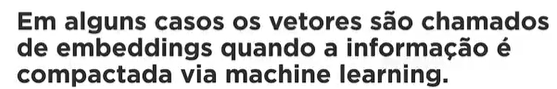

Uma vez que temos a representação dos items ou dos usuários em termos de vetores conseguimos fazer um cálculo de similaridade em cima desses vetores. Existem diversas funções que sãoutilizadas para calcular essa similaridade:

1- distância euclidiana;

2- similaridade cosseno;

3- distância jaccard;

4- distância chebyshev

Como usamos essas representações ? Ou famos cálculos de similaridade entre os items mas tambem podemos calcular a função de preferência:

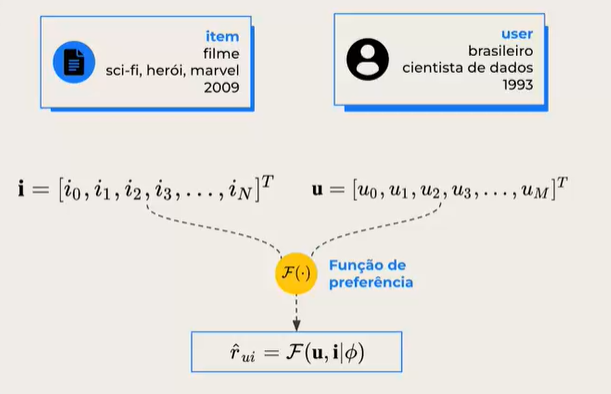

Ess função de preferência ela vai ser uma função que toma como parâmetros o vetor do usuário, o vetor do item e ela vai aprender a partir de alguns parâmetros treinados a estimar qual é o feedback de um usuário pra um determinado item. 





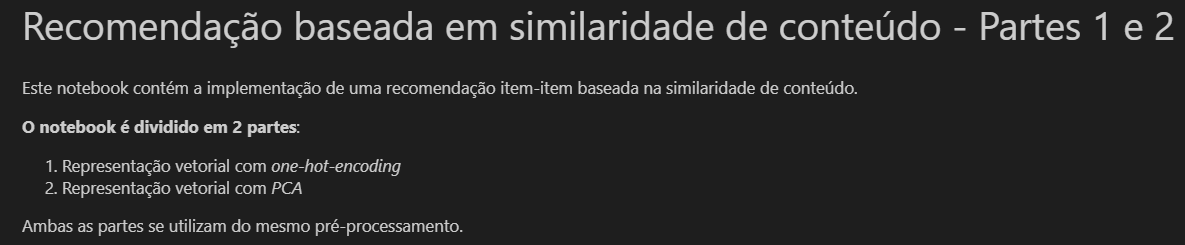

In [1]:
import os
import json
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])

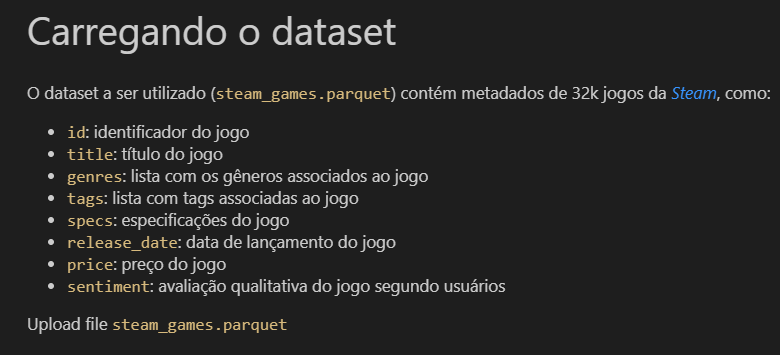

Carregando o dataset no ambiente do Colab:

In [2]:
%%time
_ = files.upload()

Saving steam_games.parquet to steam_games (1).parquet
CPU times: user 661 ms, sys: 68.9 ms, total: 730 ms
Wall time: 56.2 s


In [3]:
filepath = './steam_games.parquet'
df = pd.read_parquet(filepath)
df.set_index('id', inplace=True)
df.tail()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
id,,,,,,,,,,,,,,,
773640,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,"Nikita ""Ghost_RUS""",None,nan
733530,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,Sacada,None,nan
610660,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,Laush Dmitriy Sergeevich,None,nan
658870,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,"xropi,stev3ns",1 user reviews,nan
681550,None,None,Maze Run VR,None,http://store.steampowered.com/app/681550/Maze_...,None,"[Early Access, Adventure, Indie, Action, Simul...",NaN,http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,True,None,Positive,nan


Vamos utilizar algumas informações desse dataset pra fazer uma recomendação item item, ou seja, dado que eu tenha um jogo quais são os jogos similares aquele jogo que eu possa recomendar para os usuários. Primeiro vamos começar a fazer o pré-processamento pra criar a representação vetorial de cada jogo.

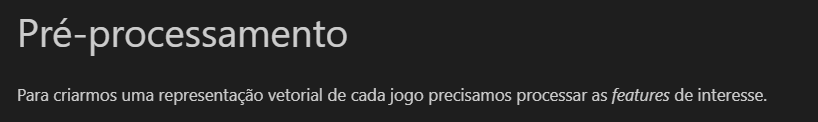

Vou criar um dataframe chamado df_features que vai ser uma cópia do dataframe original, apenas pra não misturar as transformações do dataset original com o dataset pré-processado.

In [4]:
df_features = df.copy()

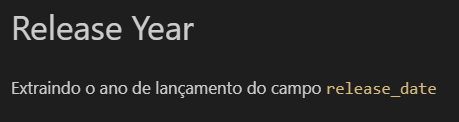

In [6]:
df_features['release_date']

id
761140    2018-01-04
643980    2018-01-04
670290    2017-07-24
767400    2017-12-07
773570          None
             ...    
773640    2018-01-04
733530    2018-01-04
610660    2018-01-04
658870    2017-09-02
681550          None
Name: release_date, Length: 19442, dtype: object

Queremos extrair apenas o ano e vamos ver que em alguns caso esse ano está como none, então o 1º pré-processamento que fazemos nesse dataset é justamente aplicar a função extract_year que recebe como parâmetro o ano de lançamento de um determinado jogo. Pra tirar o ano aplicamos uma série de expressões regulares

In [5]:
import re
def extract_year(release_date):
    if type(release_date) == str and re.match('^\d{4}-\d{2}-\d{2}$', release_date):
        return release_date.split('-')[0]

df_features['release_year'] = df_features['release_date'].apply(extract_year)
df_features[['release_date', 'release_year']].head()

,release_date,release_year
id,,
761140,2018-01-04,2018
643980,2018-01-04,2018
670290,2017-07-24,2017
767400,2017-12-07,2017
773570,None,None


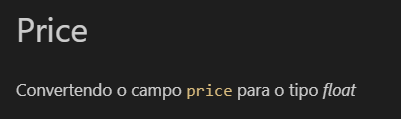

No campo price alguns dados são numéricos outros categóricos, transformando de categórico pra numérico, usamos:

In [7]:
def convert_price(price):
    try:
        return float(price)
    except:
        return 0.0
df_features['price_'] = df_features['price'].apply(convert_price)
df_features[['price', 'price_']].head()

,price,price_
id,,
761140,4.99,4.99
643980,Free To Play,0.00
670290,Free to Play,0.00
767400,0.99,0.99
773570,2.99,2.99


Se quisermos olhar os tipos:

In [10]:
df_features[['price', 'price_']].dtypes

price      object
price_    float64
dtype: object

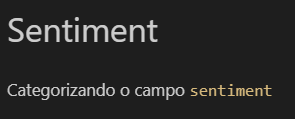

Mostrando os valores únicos do campo sentimento 

In [11]:
df_features['sentiment'].unique()

array([None, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       'Very Negative', 'Positive', 'Mostly Negative', '9 user reviews',
       'Negative', '4 user reviews', '7 user reviews', '2 user reviews',
       'Overwhelmingly Negative'], dtype=object)

A ideia do próximo código é transformar essas informações categóricas em numericas. Se consegue fazer isso através de um mapeamento entre campo categórico e o campo numérico.

Por que fomos no esquema de +4 até -4? pq quando o sentimento for mixed = 0

In [8]:
sentiment_map = {
    'Overwhelmingly Positive': 4,
    'Very Positive': 3,
    'Mostly Positive': 2,
    'Positive': 1,
    'Mixed': 0,
    'Negative': -1,
    'Mostly Negative': -2,
    'Very Negative': -3,
    'Overwhelmingly Negative': -4
}
df_features['sentiment_'] = df_features['sentiment'].map(sentiment_map).fillna(0)
df_features[['sentiment', 'sentiment_']].head()

,sentiment,sentiment_
id,,
761140,None,0.0
643980,Mostly Positive,2.0
670290,Mostly Positive,2.0
767400,None,0.0
773570,None,0.0


Vejam que em vários casos quando não temos entrada. O campo sentimento transformado aparece com none, pra resolver só complementa com fillna quando esse campo for nulo.

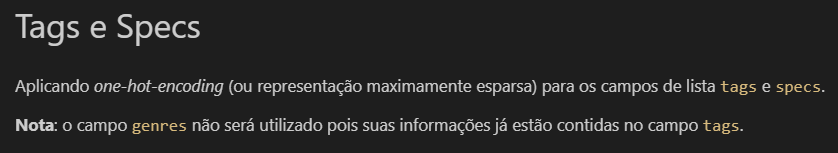

Tags têm algumas tags associadas aos jogos e o specs vem dizendo as especifidades daquele jogo. A idea vai ser aplica on-hot-encoding code, ou representação maximamente esparsa.

In [14]:
df_features['tags']

id
761140        [Strategy, Action, Indie, Casual, Simulation]
643980    [Free to Play, Strategy, Indie, RPG, Card Game...
670290    [Free to Play, Simulation, Sports, Casual, Ind...
767400                          [Action, Adventure, Casual]
773570                      [Action, Indie, Casual, Sports]
                                ...                        
773640                [Strategy, Indie, Casual, Simulation]
733530                            [Strategy, Indie, Casual]
610660                          [Indie, Simulation, Racing]
658870    [Indie, Casual, Puzzle, Singleplayer, Atmosphe...
681550    [Early Access, Adventure, Indie, Action, Simul...
Name: tags, Length: 19442, dtype: object

O campo de tag é composto por listas pra construirmos o one-hot-encoding iremos explodir esse campo aonde varias linhas são compostas por listas.

In [15]:
pd.get_dummies(df_features['tags'].explode())

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
id,,,,,,,,,,,,,,,,,,,,,
761140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
761140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
761140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
761140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
761140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Toda vez que aparecer a tag 1980 ele vai colocar o número 1, toda vez que aparecer 2D Fighter ele vai colocar 1, por isso que chamamos de representação maximamente esparsa pq vão aparecer muitos zeros nessa representação a ponto que no final nós vamos ter quase 340 colunas como features em nossos jogos.

Note que um jogo aparece várias vezes pq explodimos as linhas em várias linhas, uma com cada valor em nossa lista, podemos agrupar esse campo por item e vamos pegar o valor máximo de todos esses campos pq a maioreia desses campos vão estar preenchidos como 1, então só precisamos do maior valor que um determinado campo tem. O jogo de id 10 ele tem a tag 1980 e 1990 como tags associadas a ele. E ai, cada jogo desse vai poder ser representado por uma série de features, cada uma representando uma tag diferente 

In [17]:
pd.get_dummies(df_features['tags'].explode()).groupby('id').max()

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
id,,,,,,,,,,,,,,,,,,,,,
10,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
100980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99700,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Vamos salvar todas essas informações em dois dataframes:


In [12]:
def clean_list_column(list_column):
    return list_column if type(list_column) == list else []

# df_features['tags_'] = df_features['tags'].apply(clean_list_column)
# df_features['specs_'] = df_features['specs'].apply(clean_list_column)

df_tags = pd.get_dummies(df_features['tags'].explode()).groupby('id').max()
df_specs = pd.get_dummies(df_features['specs'].explode()).groupby('id').max()

df_tags.head()

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
id,,,,,,,,,,,,,,,,,,,,,
10,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
100980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Podemos criar um dataframe para treinamento pra todos os modelos que vamos aplicar.

Seleciona uma série de features base, ou seja, features que não sofreram o preocesso de one-hot-encoding e concatenamos as informações de tags através do indices entre os diferentes dataframes.

In [13]:
BASE_FEATURES = ['price_', 'sentiment_', 'release_year']
df_train = df_features[BASE_FEATURES].merge(df_tags, left_index=True, right_index=True)
df_train = df_train.merge(df_specs, left_index=True, right_index=True)
df_train.tail()

,price_,sentiment_,release_year,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
9970,9.99,-2.0,2011,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99700,9.99,3.0,2011,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9980,6.99,0.0,2010,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99900,0.00,3.0,2011,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
99910,0.00,3.0,2011,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


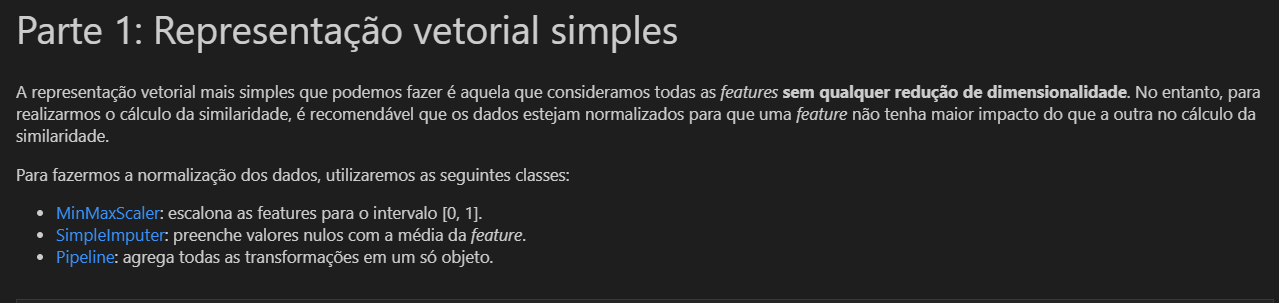

Criando pipeline da seguinte forma: 
recebe como parâmetro lista de tuplas que vai ser o passo a passo da transformação que queremos fazer no dataframe, queremos fazer o inputer dos dados que estão nulos depois fazer um escalonamento.

Precisamos fazer um pipeline.fit() pra treinar esse pipeline, precisamos passar qual a base de referencia pra treinar esse pipeline. 

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

pipeline.fit(df_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

Podemos chamar um pipeline transforme pra ver como fica os dados depois dessa transformação. 

In [26]:
pipeline.transform(df_train).shape

(19442, 381)

A função vai indicar quais são as colunas que estão sendo representadas. 

In [23]:
def generate_vector_representation(pipeline:Pipeline, preprocessed_data:pd.DataFrame, keep_columns=True):
    df_vectors = pd.DataFrame(pipeline.transform(preprocessed_data))
    if keep_columns:
        df_vectors.columns = preprocessed_data.columns
    df_vectors.index = preprocessed_data.index
    df_vectors.index.name = 'id'
    return df_vectors
df_vectors = generate_vector_representation(pipeline, df_train)
df_vectors.tail()

,price_,sentiment_,release_year,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
9970,0.012945,0.250,0.836735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99700,0.012945,0.875,0.836735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9980,0.009058,0.500,0.816327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99900,0.000000,0.875,0.836735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99910,0.000000,0.875,0.836735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


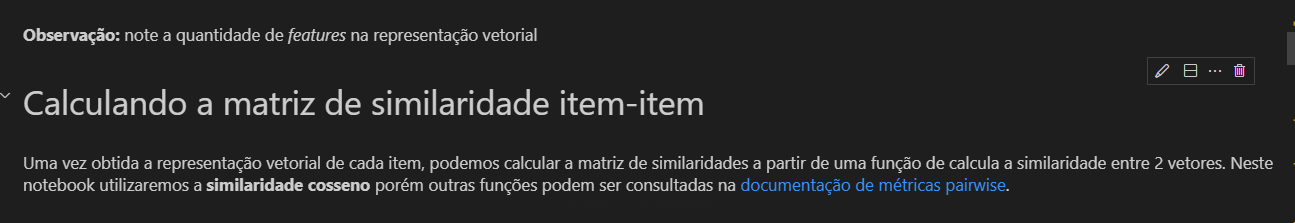

A função calculate_similarity_matrix serve pra preencher as colunas e linhas com alguns nomes pra ficar mais **bonito**, pegando as 5 primeiras linhas e as 5 primeiras colunas desse dataframe

Podemos usar essa matriz de similaridade item  item pra fazer a recomendação. Pra isso, precisamos de um pivor, a partir dele vamos encontrar quais são os itens similares a eles.


In [29]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity_matrix(vectors:pd.DataFrame, similarity_fn=cosine_similarity):
    similarity_matrix = pd.DataFrame(similarity_fn(vectors))
    similarity_matrix.index = vectors.index.astype(str)
    similarity_matrix.index.name = 'id'
    similarity_matrix.columns = vectors.index.astype(str)
    return similarity_matrix

df_item_similarity_matrix = calculate_similarity_matrix(df_vectors)
df_item_similarity_matrix.iloc[:5, :5]

CPU times: user 9.85 s, sys: 1.92 s, total: 11.8 s
Wall time: 8.77 s


id,10,1002,100400,10090,100980
id,,,,,
10,1.000000,0.253148,0.145029,0.391773,0.154565
1002,0.253148,1.000000,0.226340,0.336925,0.233593
100400,0.145029,0.226340,1.000000,0.147372,0.705245
10090,0.391773,0.336925,0.147372,1.000000,0.154867
100980,0.154565,0.233593,0.705245,0.154867,1.000000


Podemos 

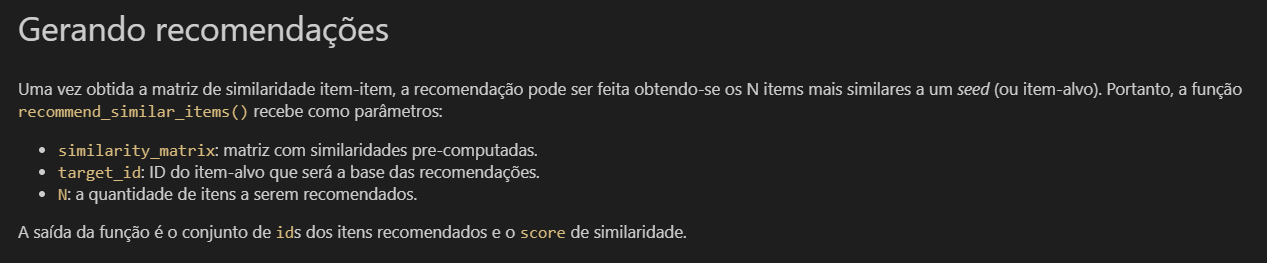

recommend_similar_items vai receber a matriz de similaridade, target id que é nosso pivô e o número de recomendações que a gente precisa fazer.
Primeiro passo é obter as similaridades desse item que é nosso alvo. Podemos fazer um .loc pra buscar a informação de um determinado indice.
Tendo essas similaridades podemos ordenar de forma decrescente.

Estamos usando a similaridade como score da nossa recomendação, precisamos pegar os tops n depois voltando como index da nossa recomendação

In [28]:
id = '12180'  # Grand Theft Auto 2 

def recommend_similar_items(similarity_matrix:pd.DataFrame, target_id:str, n=10):
    target_item_similarities = similarity_matrix.loc[target_id]
    id_similar_items = (
        target_item_similarities
        .sort_values(ascending=False)
        .reset_index()
        .rename({'index': 'id', target_id: 'score'}, axis=1)
    )
    return id_similar_items.head(n).set_index('id')

df_recommended_items = recommend_similar_items(df_item_similarity_matrix, id)
df_recommended_items

,score
id,
12180,1.000000
12170,0.704370
38430,0.669960
40990,0.647127
2610,0.628885
38490,0.626514
901147,0.621112
6850,0.609481
6880,0.607819


Vamos ter os jogos mais similares ao pivô.

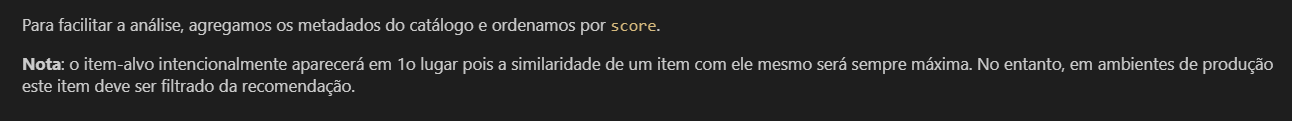

In [30]:
def display_recommendations(recommendations:pd.DataFrame, catalog:pd.DataFrame):
    return (
        recommendations
        .merge(catalog, left_index=True, right_index=True, how='inner')
        .sort_values(by='score', ascending=False)
    )

display_recommendations(df_recommended_items, df[['title', 'tags']])

,score,title,tags
id,,,
12180,1.000000,Grand Theft Auto 2,"[Action, Classic, Open World, Singleplayer, Sh..."
12170,0.704370,Grand Theft Auto,"[Action, Classic, Open World, Singleplayer, 2D..."
38430,0.669960,Kingpin — Life of Crime,"[Action, FPS, Singleplayer, Crime, Classic, Go..."
40990,0.647127,Mafia,"[Action, Adventure, Violent, Story Rich, Class..."
2610,0.628885,GUN™,"[Western, Action, Open World, Third-Person Sho..."
38490,0.626514,Earthworm Jim 2,"[Adventure, Action, Classic, Platformer, 2D]"
901147,0.621112,Earthworm Jim,"[Action, Adventure, Platformer, Classic, 2D]"
6850,0.609481,Hitman 2: Silent Assassin,"[Stealth, Action, Third Person, Singleplayer, ..."
6880,0.607819,Just Cause,"[Action, Open World, Shooter, Third Person, Si..."


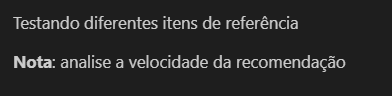

In [31]:
id = '12180'  # Grand Theft Auto 2 
id = '10'     # Counter Striker
# id = '221040' # Resident Evil 6
# id = '252950' # Rocket League
# id = '338300' # Disney'Chicken
# id = '226580' # F1
# id = '260210' # Assassin's Creed
df_recommended_items = recommend_similar_items(df_item_similarity_matrix, id)
display_recommendations(df_recommended_items, df[['title', 'tags']])

,score,title,tags
id,,,
10,1.000000,Counter-Strike,"[Action, FPS, Multiplayer, Shooter, Classic, T..."
80,0.642664,Counter-Strike: Condition Zero,"[Action, FPS, Shooter, Multiplayer, Singleplay..."
240,0.636572,Counter-Strike: Source,"[Action, FPS, Multiplayer, Shooter, Team-Based..."
30,0.595415,Day of Defeat,"[FPS, World War II, Multiplayer, Action, Shoot..."
730,0.586448,Counter-Strike: Global Offensive,"[FPS, Multiplayer, Shooter, Action, Team-Based..."
40,0.573326,Deathmatch Classic,"[Action, FPS, Multiplayer, Classic, Shooter, F..."
360,0.571086,Half-Life Deathmatch: Source,"[Action, FPS, Multiplayer, Sci-fi, Shooter, Fi..."
1200,0.565722,Red Orchestra: Ostfront 41-45,"[Action, World War II, FPS, Realistic, Multipl..."
222880,0.539604,Insurgency,"[FPS, Realistic, Tactical, Multiplayer, Action..."


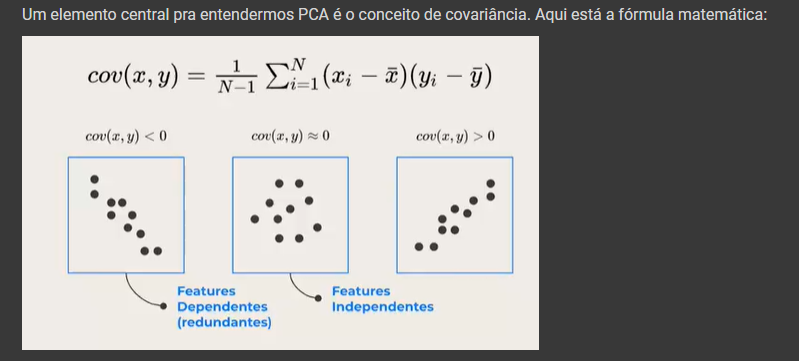

A covariância explica como que os dados andam juntos entre si. Imagina que temos duas features que eças parecem andar de forma linear uma com a outra. O ponto é, se existe uma dependência entre essas duas features, a covariância vai indicar um pouco dessa dependencia. Se uma features tá subindo e a outra tá descendo, temos uma covariância negativa.
Quando as features não tem correlação entre si, dizemos que elas são independetes, e é isso que geralmente queremos na entrada do modelo de machine learning, queremos que as features sejam idependentes entre si porém dependentes de uma saida, por exemplo quando estamos trabalhando com modelos supervisionados, entao a ideia da PCA é justamente trabalhar com essa covariância e fazer uma redução dessa features de forma que podemoas aplicar esse modelo.

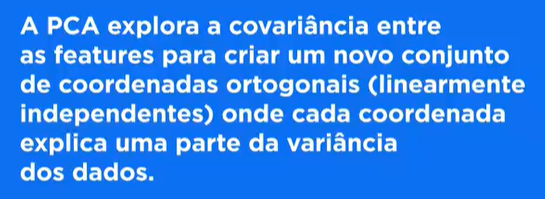

Imaginemos que temos essas 2 features, que são dependentes, quando uma cresce a outra diminue.A PCA vai mudar o espaço de referência, ao invés de trabalhar com esses eixos vamos trabalhar com outros eixos de forma que o 1º eixo explica a maior parte da variância dos meus dados:

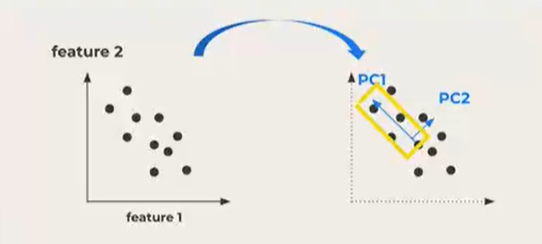

2ª maior dos meus dados, a ideia é achar esses eixos de forma que esses eixos sejam ortogonais entre si

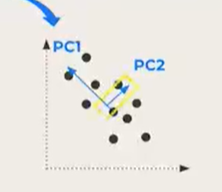

Então a motivação da PCA é justamente é transformar os dados em uma nova base de coordenadas de forma que conseguimos ter um pouco de noção de componentes principais que expliquem um pouco da vairância dos seus dados. Então se uma componente principal ela explica a maior parte da variância dos seus dados, 2º componente explica a outra parte e assim por diante, a gente consegue ver o quanto cada componente explica da variância dos seus dados 

Esse é um gráfico bem utilizado quando aplica PCA, o eixo x é as componentes principais e nesse primeiro y temos a variância explicada daquela componente principal.Então a variância principal está explicando em 85% da minha variância, enquanto que conforme eu vou pegando componentes principais mais a direita, ela vai explicando cada vez menos a variância dos meus dados.

O gráfico de baixo nada mais é do que essa variância acumulada, o que aocntecerei se eu considerar somente as duas primeiras componentes principais, se eu considerar somente as 10 componentes principais, e assim por diante..até a n-ésima

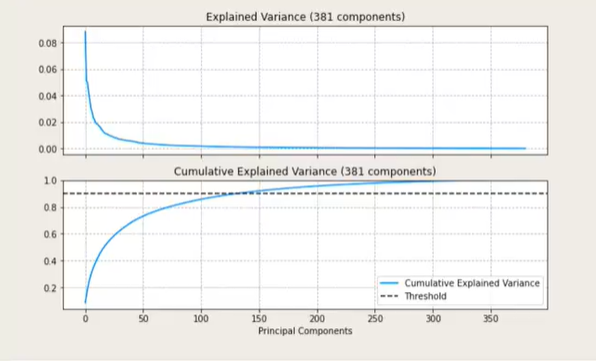

Pra explicar 90% (a gente que determina) da variância dos nossos dados, precisamos de em torno de 130,140 componetntes principais

O que queremos fazer, pegar os dados originais com dimensão m (colunas), aplicar uma transformação que no caso é a PCA em cima desses dados originais e por fim chegar com dados com uma dimensao k muito menor do que a dimensão original dos nossos dados:

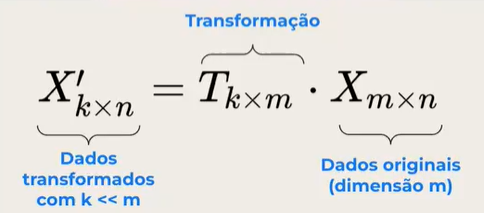

Pra isso precisamos da matriz de transformação da PCA.

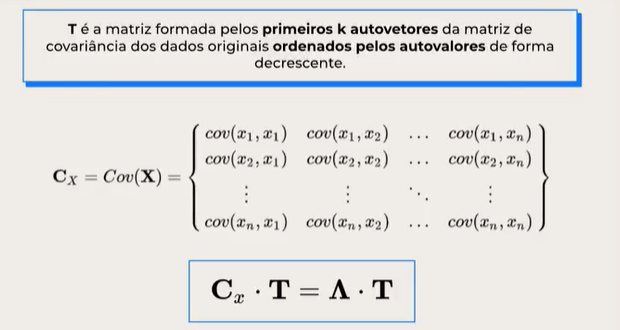

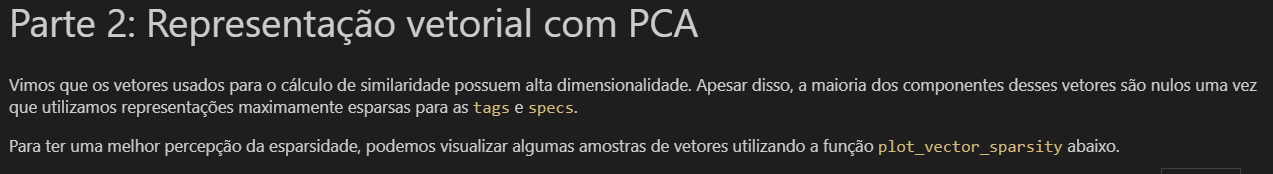

In [32]:
print ('Dimensão dos vetores:', df_vectors.shape[1])

Dimensão dos vetores: 381


plot_vector_sparsity plota a esparsidade da atriz de entrada como também toda criação de plots 

Vemos que pros 100 primeiros vetores a esparsidade que temos é de 96.45 %. Apesar de estarmos trabalhando com uma matriz com 381 vetores, a maior parte é nula. Então será que temos como diminuir essa falta de informação e deixar os vetores um poucom mais preenchidos pra calcular a similaridade de forma mais esperta.

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Vectors Sparsity (Sparsity = 96.45 %)'}, xlabel='Vector element', ylabel='Vector sample'>)

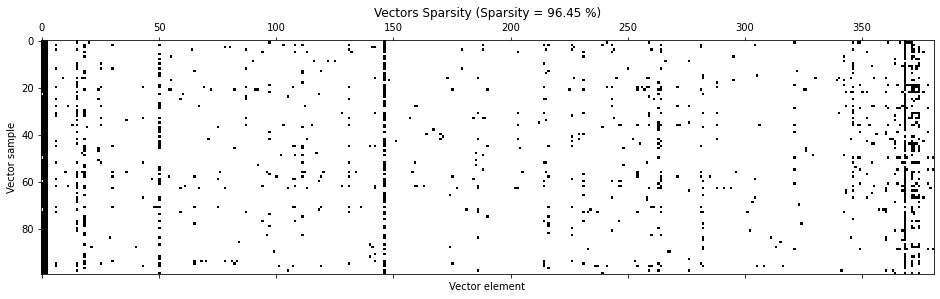

In [33]:
def plot_vector_sparsity(vectors:pd.DataFrame, figsize=(16, 10), n_samples=100):
    filled_entries = vectors.astype(bool).sum().sum()
    overall_sparsity = 1-filled_entries/(vectors.shape[0]*vectors.shape[1])

    fig, ax = plt.subplots(figsize=figsize)
    ax.spy(vectors.sample(n_samples))
    ax.set_title('Vectors Sparsity (Sparsity = {:.02f} %)'.format(100*overall_sparsity))
    ax.set_xlabel('Vector element')
    ax.set_ylabel('Vector sample')
    return fig, ax

plot_vector_sparsity(df_vectors, n_samples=100)

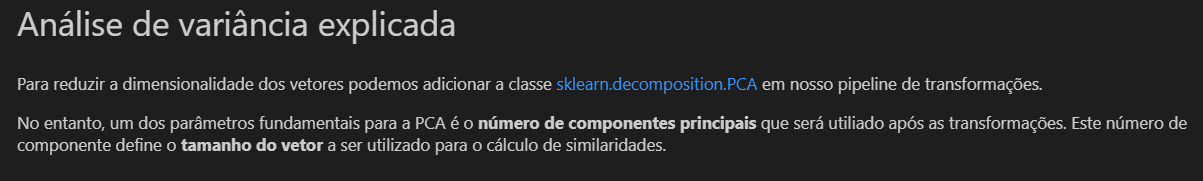

Aplicando a PCA

In [34]:
from sklearn.decomposition import PCA
n_components = df_train.shape[1]

pipeline_pca = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('decomposition', PCA(n_components=n_components))
])

pipeline_pca.fit(df_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('decomposition', PCA(n_components=381))])

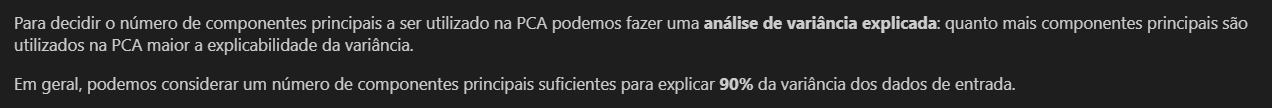

(<Figure size 864x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Cumulative Explained Variance (381 components)'}, xlabel='Principal Components'>)

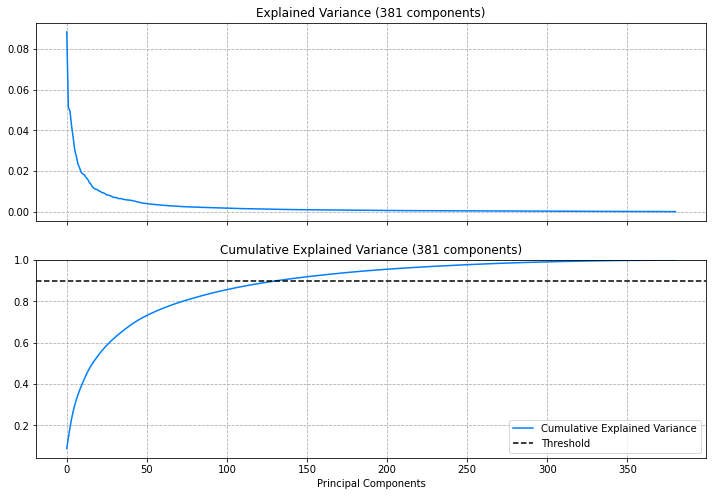

In [35]:
def plot_explained_variance(explained_variance, figsize=(16,8), threshold=0.9, cumulative=True):
    label = 'Explained Variance'
    n_componenents = len(explained_variance)

    fig, axes = plt.subplots(nrows=2, figsize=figsize, sharex=True)

    ax = axes[0]
    ax.plot(explained_variance, label=label)

    ax.set_title(f'{label} ({n_components} components)')

    ax = axes[1]
    label = f'Cumulative {label}'
    ax.plot(np.cumsum(explained_variance), label=label)
    ax.axhline(threshold, c='black', linestyle='--', label='Threshold')
    ax.set_title(f'{label} ({n_components} components)')
    ax.set_xlabel('Principal Components')
    ax.set_ylim(top=1.0)
    ax.legend()
    [ax_i.grid(True, linestyle='--') for ax_i in axes]
    return fig, ax

explained_variance_ratio = pipeline_pca.named_steps['decomposition'].explained_variance_ratio_
plot_explained_variance(explained_variance_ratio, cumulative = False, figsize=(12,8))

  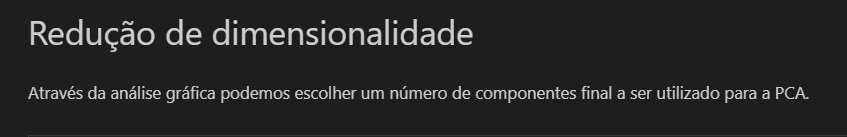

In [36]:
n_components = 150
pipeline_pca = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('decomposition', PCA(n_components=n_components))
])

pipeline_pca.fit(df_train)

df_vectors_pca = generate_vector_representation(pipeline_pca, df_train, keep_columns=False)
df_vectors_pca.tail()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
id,,,,,,,,,,,,,,,,,,,,,
9970,-0.678987,-0.427745,0.392028,-0.143320,-0.671988,0.127962,0.131818,0.266490,-0.766825,-0.197784,...,-0.021205,-0.005037,-0.009346,-0.008765,-0.025700,-0.007276,0.005001,0.020001,-0.002125,0.003037
99700,0.045390,-0.225525,-0.615700,0.374983,0.730148,0.123234,1.159890,0.966161,0.532615,0.382058,...,-0.105861,-0.012461,-0.062750,0.046868,-0.048589,-0.039528,-0.057357,0.016395,-0.062462,0.020540
9980,-0.854433,-0.377767,-0.552167,0.089070,0.203783,-0.073796,0.816582,-0.242471,0.068920,-0.108289,...,-0.055312,-0.036740,-0.081504,0.030737,-0.086989,0.000521,-0.076074,0.030194,-0.064918,0.005815
99900,1.669908,-0.189964,1.205550,0.582277,0.685167,1.183369,0.024355,-1.069412,-0.310266,0.859328,...,0.064283,-0.024779,0.156427,0.052855,-0.115076,-0.004689,-0.065394,-0.052185,-0.071935,-0.199999
99910,0.239036,-0.474338,0.485375,0.000911,1.173145,0.509232,0.430435,-1.146643,0.524939,0.008349,...,0.037748,0.012845,-0.039872,-0.020502,-0.015031,0.054208,-0.065957,-0.005975,-0.094063,-0.060071


In [37]:
print ('Dimensão dos vetores (pré-PCA):', df_vectors.shape[1])
print ('Dimensão dos embeddings (pós-PCA):', df_vectors_pca.shape[1])

Dimensão dos vetores (pré-PCA): 381
Dimensão dos embeddings (pós-PCA): 150


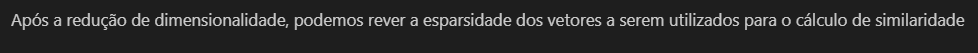

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Vectors Sparsity (Sparsity = 0.00 %)'}, xlabel='Vector element', ylabel='Vector sample'>)

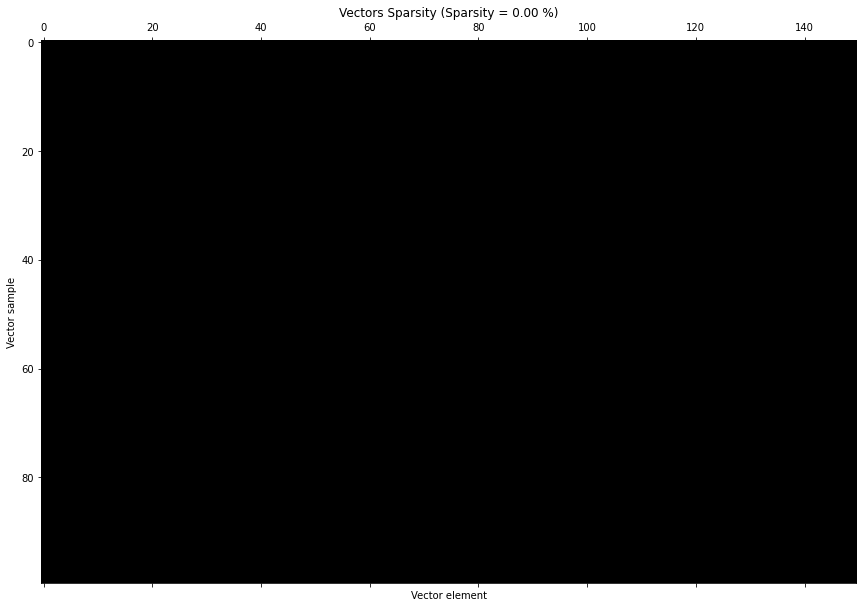

In [38]:
plot_vector_sparsity(df_vectors_pca, n_samples=100)

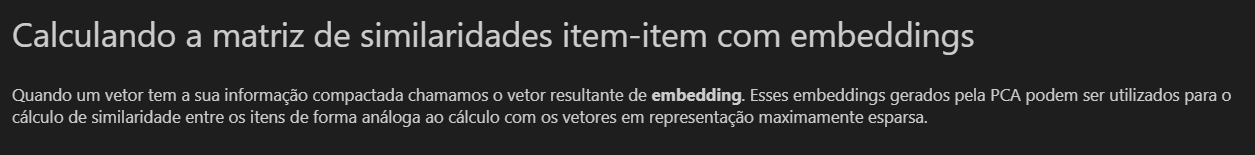

In [39]:
%%time
df_item_similarity_matrix_pca = calculate_similarity_matrix(df_vectors_pca)
df_item_similarity_matrix_pca.shape 

CPU times: user 6.75 s, sys: 9.04 s, total: 15.8 s
Wall time: 12.1 s


(19442, 19442)

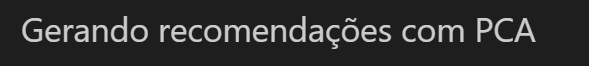

In [40]:
id = '12180'    # Grand Theft Auto 2
df_recommended_items_pca = recommend_similar_items(df_item_similarity_matrix_pca, id)
display_recommendations(df_recommended_items_pca, df[['title', 'tags']])  

,score,title,tags
id,,,
12180,1.000000,Grand Theft Auto 2,"[Action, Classic, Open World, Singleplayer, Sh..."
12170,0.689116,Grand Theft Auto,"[Action, Classic, Open World, Singleplayer, 2D..."
38430,0.590687,Kingpin — Life of Crime,"[Action, FPS, Singleplayer, Crime, Classic, Go..."
2610,0.574537,GUN™,"[Western, Action, Open World, Third-Person Sho..."
40990,0.552463,Mafia,"[Action, Adventure, Violent, Story Rich, Class..."
299050,0.552214,Blood II: The Chosen + Expansion,"[Action, Adventure, FPS, Gore, Classic, Horror..."
6880,0.524241,Just Cause,"[Action, Open World, Shooter, Third Person, Si..."
358370,0.520523,Terminal Velocity,"[Action, 1990's, Shooter, 6DOF, Classic, Singl..."
12100,0.518105,Grand Theft Auto III,"[Open World, Action, Classic, Third Person, Si..."


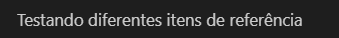

In [41]:
id = '12180'  # Grand Theft Auto 2 
# id = '10'     # Counter Striker
# id = '221040' # Resident Evil 6
# id = '252950' # Rocket League
# id = '338300' # Disney'Chicken
# id = '226580' # F1
# id = '260210' # Assassin's Creed
df_recommended_items_pca = recommend_similar_items(df_item_similarity_matrix_pca, id)
display_recommendations(df_recommended_items_pca, df[['title', 'tags']])

,score,title,tags
id,,,
12180,1.000000,Grand Theft Auto 2,"[Action, Classic, Open World, Singleplayer, Sh..."
12170,0.689116,Grand Theft Auto,"[Action, Classic, Open World, Singleplayer, 2D..."
38430,0.590687,Kingpin — Life of Crime,"[Action, FPS, Singleplayer, Crime, Classic, Go..."
2610,0.574537,GUN™,"[Western, Action, Open World, Third-Person Sho..."
40990,0.552463,Mafia,"[Action, Adventure, Violent, Story Rich, Class..."
299050,0.552214,Blood II: The Chosen + Expansion,"[Action, Adventure, FPS, Gore, Classic, Horror..."
6880,0.524241,Just Cause,"[Action, Open World, Shooter, Third Person, Si..."
358370,0.520523,Terminal Velocity,"[Action, 1990's, Shooter, 6DOF, Classic, Singl..."
12100,0.518105,Grand Theft Auto III,"[Open World, Action, Classic, Third Person, Si..."


In [42]:
id = df.sample().index[0]
df_recommended_items_pca = recommend_similar_items(df_item_similarity_matrix_pca, id)
display_recommendations(df_recommended_items_pca, df[['title', 'tags']])

,score,title,tags
id,,,
335670,1.000000,LISA,"[Dark Humor, RPG, Great Soundtrack, Story Rich..."
420530,0.613870,OneShot,"[Pixel Graphics, Story Rich, Indie, Great Soun..."
483980,0.609744,Mad Father,"[RPGMaker, Horror, Anime, Indie, Adventure, 2D..."
337340,0.608304,Finding Paradise,"[Story Rich, Great Soundtrack, Indie, Adventur..."
420740,0.602245,The Deed,"[RPGMaker, Adventure, Crime, Atmospheric, Dete..."
265470,0.594964,Even the Ocean,"[Indie, Adventure, Action, Female Protagonist,..."
691450,0.592045,Misao: Definitive Edition,"[Indie, Adventure, Casual, Horror, RPGMaker, A..."
391540,0.586786,Undertale,"[Great Soundtrack, Story Rich, Choices Matter,..."
389170,0.570812,A Lenda do Herói - O Herói desta Canção,"[Adventure, Great Soundtrack, Indie, Platforme..."
